In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.special import kn as besselk  # Modified Bessel K_n

# --- Constants and parameters ---
Mpl = 1.2209e19  # Planck mass in GeV
OMEGA_PREF = 2.742e8  # Omega h^2 = OMEGA_PREF * (m/GeV) * Y0
m_DM = 100  # GeV
GeV2_to_cm3s = 1.1663787e-17      # (σv)[GeV^-2] -> cm^3/s
cm3s_to_GeV2 = 1.0 / GeV2_to_cm3s # (σv)[cm^3/s] -> GeV^-2
sigma_v_list_cm3s = [1e-33,1e-32,1e-31]
sigma_v_list = [sv * cm3s_to_GeV2 for sv in sigma_v_list_cm3s]

x_min = 1e-1
x_max = 100.0
nx = 250

# --- Helper functions ---
def s_entropy(T, g_s=90.0):                                                 #Entropy density s(T) = (2*pi^2/45) g_s T^3
    return (2.0 * np.pi**2 / 45.0) * g_s * T**3

def hubble(T, g_eff=90.0):                                                  #Hubble parameter H(T) = 1.66 sqrt(g_eff) T^2 / Mpl
    return 1.66 * np.sqrt(g_eff) * T**2 / Mpl

def Y_eq(x, m, g=2, g_s=90.0):                                              #Equilibrium yield Y_eq(x)
    pref = 45.0 / (4.0 * np.pi**4)
    return pref * (g / g_s) * x**2 * besselk(2, x)

def dYdx(x, Y, m, sigma_v, g=2, g_eff=90.0, g_s=90.0):                      #Boltzmann equation in terms of x = m/T
    T = m / x
    s = s_entropy(T, g_s=g_s)
    H = hubble(T, g_eff=g_eff)
    Yeq = Y_eq(x, m, g=g, g_s=g_s)
    coeff = - (s * sigma_v) / (x * H)
    return coeff * (Y**2 - Yeq**2)

def solve_Y(m, sigma_v, x_min=1e-2, x_max=100.0, nx=200, g=2, g_eff=90.0, g_s=90.0):    #Solve for Y(x)
    x_eval = np.unique(np.concatenate((np.logspace(np.log10(x_min), np.log10(200), int(nx*0.7)),np.linspace(200, x_max, int(nx*0.3)))))
    Y0 = Y_eq(x_min, m, g=g, g_s=g_s)
    
    sol = solve_ivp(lambda xx, YY: dYdx(xx, YY, m, sigma_v, g=g, g_eff=g_eff, g_s=g_s),(x_eval[0], x_eval[-1]), [Y0],t_eval=x_eval, rtol=1e-3, atol=1e-8)
    if not sol.success:
        raise RuntimeError("ODE solver failed: " + str(sol.message))
    
    Y = sol.y[0]
    Yeq_vals = Y_eq(x_eval, m, g=g, g_s=g_s)
    Y_final = Y[-1]
    Omega_h2 = OMEGA_PREF * m * Y_final
    return x_eval, Y, Yeq_vals, Y_final, Omega_h2



0
1
2


<Figure size 640x480 with 0 Axes>

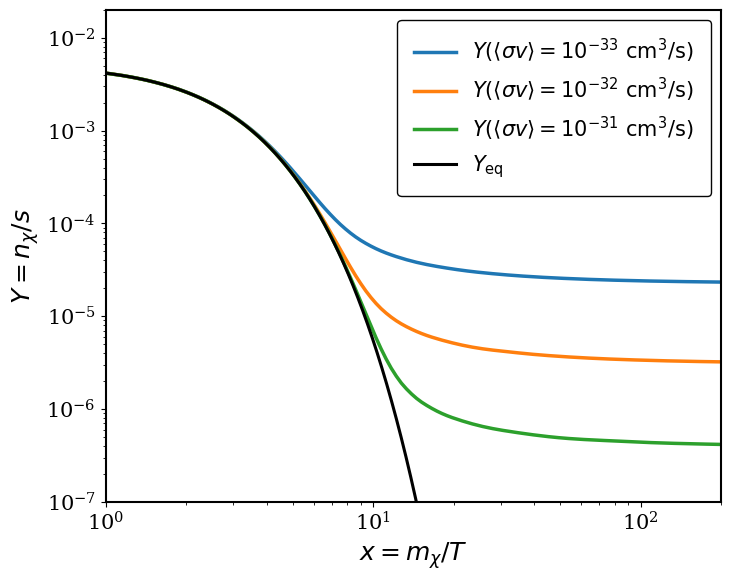

In [ ]:
# --- Solve and plot ---
results = []
plt.figure(figsize=(8,6))
import matplotlib as mpl
mpl.rcParams.update({
    "font.family": "serif",
    "font.size": 16,
    "axes.labelsize": 18,
    "axes.titlesize": 18,
    "legend.fontsize": 15,
    "xtick.labelsize": 15,
    "ytick.labelsize": 15,
    "axes.linewidth": 1.5,
    "lines.linewidth": 2.5,
    "legend.frameon": True,
    "legend.framealpha": 0.98,
    "legend.fancybox": True,
    "legend.edgecolor": "black",
    "text.usetex": False,
})

plt.clf()
fig, ax = plt.subplots(figsize=(8, 6.5))
colors = plt.get_cmap('tab10').colors
for i, (sigma_v, sigma_v_cm3s) in enumerate(zip(sigma_v_list, sigma_v_list_cm3s)):
    x, Y, Yeq_vals, Yf, Omega = solve_Y(m_DM, sigma_v, x_min, x_max, nx)
    results.append({'<σv> (cm^3/s)': sigma_v_cm3s,'<σv> (GeV^-2)': sigma_v,'Y_final': Yf,'Omega h^2': Omega,})
    ax.plot(x, Y, label=fr'$Y(\langle\sigma v\rangle=10^{{{int(np.log10(sigma_v_cm3s))}}}\ \mathrm{{cm^3/s}})$', color=colors[i % len(colors)], linestyle='-')
    print(i)
x_ref = np.logspace(np.log10(x_min), np.log10(x_max), 1000)
Yeq_ref = Y_eq(x_ref, m_DM)

# Equilibrium yield
ax.plot(
    x_ref, Y_eq(x_ref, m_DM), 
    color='black', linestyle='-', linewidth=2.2, 
    label=r'$Y_\mathrm{eq}$'
)

ax.set_xlabel(r'$x = m_{\chi} / T$')
ax.set_ylabel(r'$Y = n_{\chi}/s$')
ax.set_xlim(1, 2*100)
ax.set_ylim(1e-7, 2*1e-2)
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(loc='best', frameon=True, borderpad=0.8)



plt.tight_layout(pad=2.0)
plt.show()